In [1]:
from google.colab import drive
drive.mount("/content/drive/")


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


Mounted at /content/drive/


In [2]:
usecols = ['id', 'regulationMark', 'hp', 'name', 'types', 'subtypes', 'evolvesFrom', 'evolvesTo', 'weaknesses', 'convertedRetreatCost', 'resistances', 'cleaned_attacks', 'cleaned_abilities', 'cleaned_rules', 'tournamentYear']

pokemon_2021 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_pokemon_power_level.csv')
pokemon_2022 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_pokemon_power_level.csv')
pokemon_2023 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_pokemon_power_level.csv')
trainer_2021 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_trainer_power_level.csv')
trainer_2022 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_trainer_power_level.csv')
trainer_2023 = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_trainer_power_level.csv')


In [48]:
train_trainers_dat_x = pd.concat([trainer_2021, trainer_2022])[['id', 'name', 'cleaned_rules']]
test_trainers_dat_x = trainer_2023[['id', 'name', 'cleaned_rules']]

train_pokemon_dat_x = pd.concat([pokemon_2021, pokemon_2022])[usecols]
test_pokemon_dat_x = pokemon_2023[usecols]

train_trainers_dat_y = pd.concat([trainer_2021, trainer_2022])['power_level'].to_numpy()
test_trainers_dat_y = trainer_2023['power_level'].to_numpy()

train_pokemon_dat_y = pd.concat([pokemon_2021, pokemon_2022])['power_level'].to_numpy()
test_pokemon_dat_y = pokemon_2023['power_level'].to_numpy()

Pokemon

In [82]:
def combine_features(row):
    return ' '.join(row.values.astype(str))

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 512

# Tokenize text
train_trainers_tokenized_text = tokenizer(
    train_trainers_dat_x[['id', 'cleaned_rules']].apply(combine_features, axis=1).tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

# Tokenize text
test_trainers_tokenized_text = tokenizer(
    test_trainers_dat_x[['id', 'cleaned_rules']].apply(combine_features, axis=1).tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

# Tokenize text
train_pokemon_tokenized_text = tokenizer(
    train_pokemon_dat_x[usecols].apply(combine_features, axis=1).tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

# Tokenize text
test_pokemon_tokenized_text = tokenizer(
    test_pokemon_dat_x[usecols].apply(combine_features, axis=1).tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)


In [33]:
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1, output_hidden_states=True, output_attentions=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [34]:
# Create model

input_ids = keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

roberta_output = roberta_model(input_ids=input_ids, attention_mask=attention_mask)

logits = roberta_output.logits

model = keras.Model(inputs=[input_ids, attention_mask], outputs=logits)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246464   ['input_ids[0][0]',           
 assification_3 (TFRobertaF  (loss=None, logits=(None,    01         'attention_mask[0][0]']      
 orSequenceClassification)   1),                                                            

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

history = model.fit(
    x=dict(train_trainers_tokenized_text),
    y=train_trainers_dat_y.reshape(-1,1),
    batch_size=8,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
39/39 [==============================] - 89s 1s/step - loss: 0.0184 - mean_absolute_error: 0.0701 - val_loss: 0.0049 - val_mean_absolute_error: 0.0558
Epoch 2/20
39/39 [==============================] - 38s 970ms/step - loss: 0.0152 - mean_absolute_error: 0.0831 - val_loss: 0.0055 - val_mean_absolute_error: 0.0369
Epoch 3/20
39/39 [==============================] - 40s 1s/step - loss: 0.0138 - mean_absolute_error: 0.0618 - val_loss: 0.0074 - val_mean_absolute_error: 0.0541
Epoch 4/20
39/39 [==============================] - 41s 1s/step - loss: 0.0123 - mean_absolute_error: 0.0618 - val_loss: 0.0049 - val_mean_absolute_error: 0.0557
Epoch 5/20
39/39 [==============================] - 40s 1s/step - loss: 0.0122 - mean_absolute_error: 0.0640 - val_loss: 0.0055 - val_mean_absolute_error: 0.0463
Epoch 6/20
39/39 [==============================] - 38s 973ms/step - loss: 0.0094 - mean_absolute_error: 0.0570 - val_loss: 0.0051 - val_mean_absolute_error: 0.0428
Epoch 7/20
39/39 [====

In [36]:
roberta_model_filename = "RoBERTa_trainer_fine_tuned_v1"
model_filename = "RoBERTa_trainer_model.keras_v1"

roberta_model.save_pretrained(f"/content/drive/MyDrive/266/project/{roberta_model_filename}")
model.save(f"/content/drive/MyDrive/266/project/{model_filename}")
# bert_model = TFRobertaForSequenceClassification.from_pretrained(f"/content/drive/MyDrive/266/project/{roberta_model_filename}")
#loaded_model = keras.saving.load_model(f"/content/drive/MyDrive/266/project/{model_filename}")

In [116]:
def attention_heatmap(tokens, attention_matrix, offset=1, figsize=(20,16)):
  tokens = np.array(tokens)
  tokens_pad_idx = np.argmax(tokens == '<pad>')
  if tokens_pad_idx == 0: # no pad
    tokens_pad_idx = len(tokens)
  df = pd.DataFrame(
      attention_matrix[offset:tokens_pad_idx-1, offset:tokens_pad_idx-1],
      index=[tkn.replace('Ġ', '') for tkn in tokens[offset:tokens_pad_idx-1]],
      columns=[tkn.replace('Ġ', '') for tkn in tokens[offset:tokens_pad_idx-1]]
  )
  plt.figure(figsize=figsize)
  sns.heatmap(df, annot=False, cmap='Blues')

In [53]:
idx = np.argsort(test_trainers_dat_y)[::-1]
sorted_test_dat_y = test_trainers_dat_y[idx][:10]
sorted_test_dat_x = test_trainers_dat_x.iloc[idx,:].iloc[:10,:]

X_test_tokenized = tokenizer(
    sorted_test_dat_x[['id', 'cleaned_rules']].apply(combine_features, axis=1).tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

roberta_outputs = roberta_model(
    input_ids=X_test_tokenized['input_ids'],
    attention_mask=X_test_tokenized['attention_mask'],
)

attentions = roberta_outputs.attentions
attentions = np.array([att.numpy() for att in attentions])  # Convert to NumPy array. Shape [12, batch_size, 12, num_tokens, num_tokens]. The 12 is number of layers. The other 12 is number of attention heads.


In [54]:
pairwise_attentions = attentions.mean(axis=(0, 2)) # Shape [batch_size, num_tokens, num_tokens]

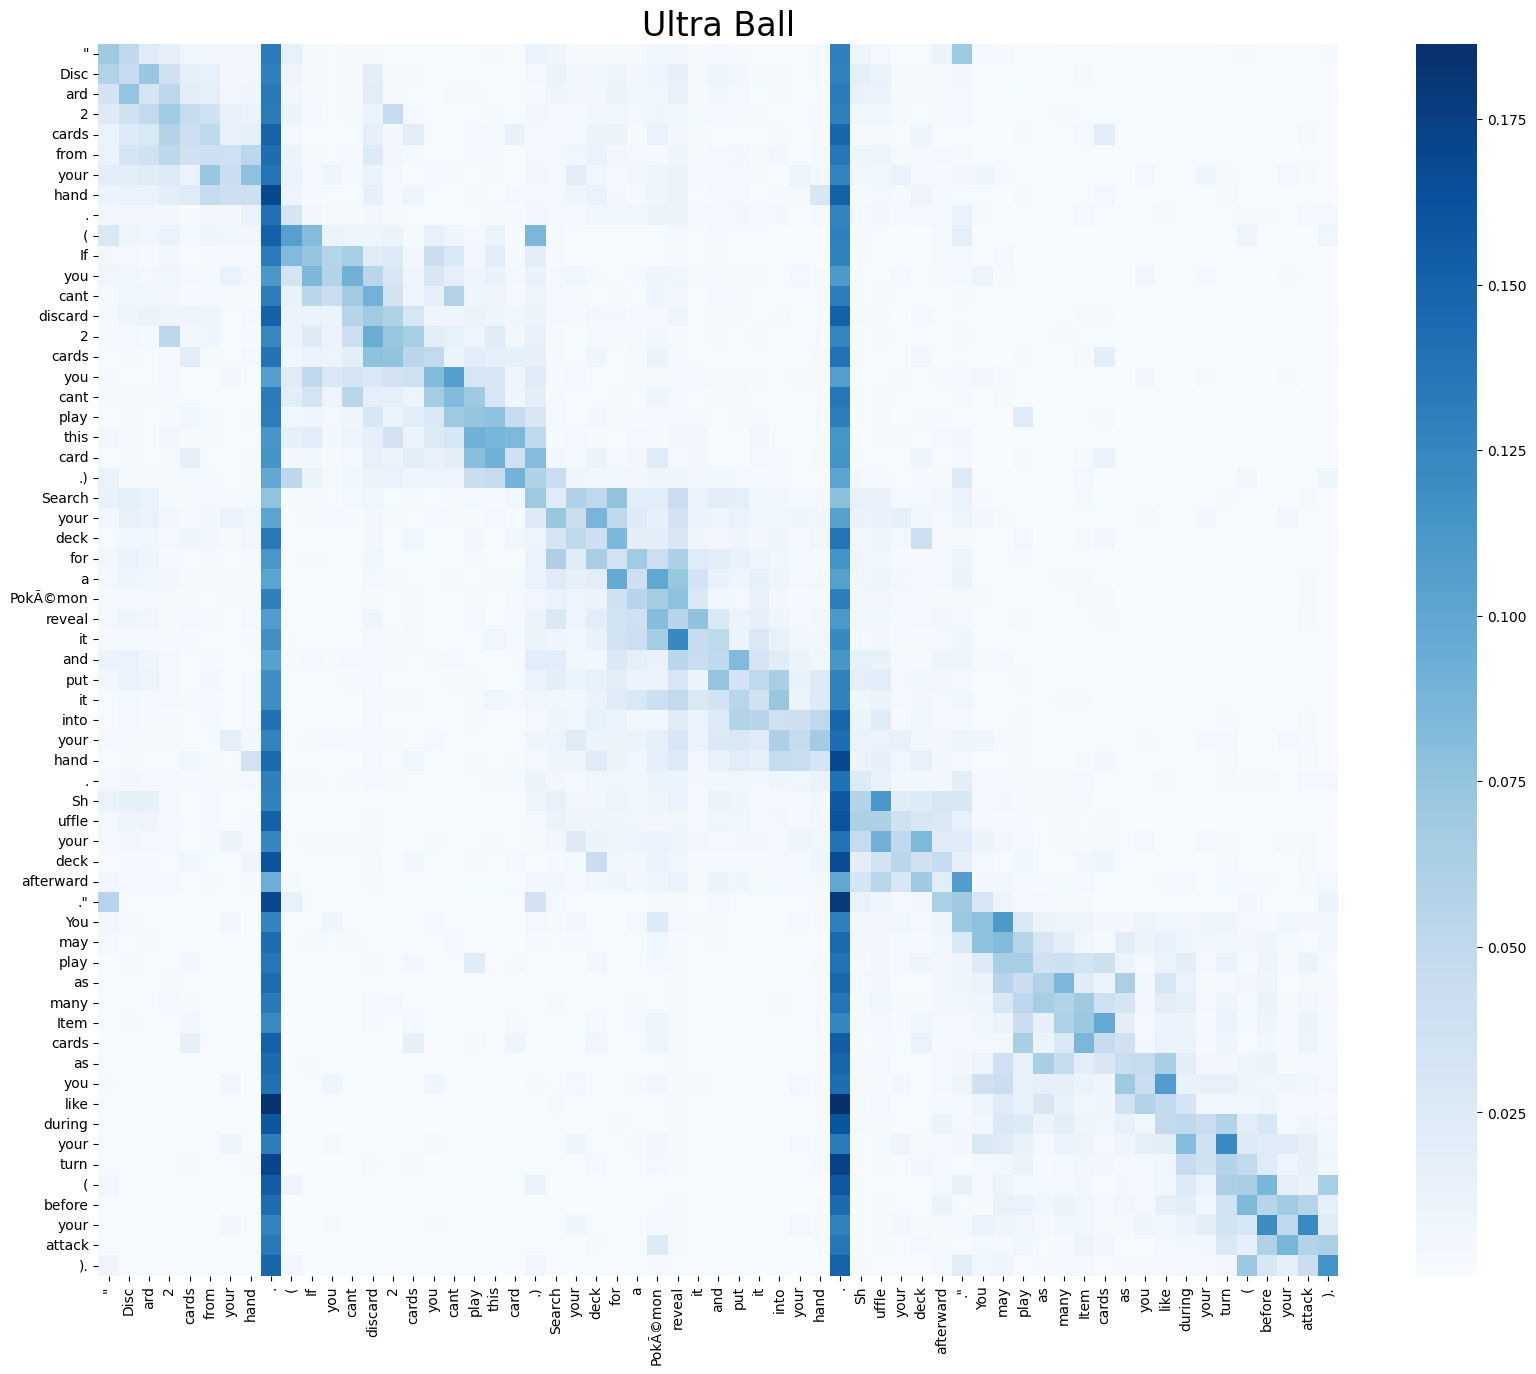

In [75]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[0]),
    pairwise_attentions[0],
    offset=6
)

plt.title(sorted_test_dat_x['name'].iloc[0], fontsize=24);

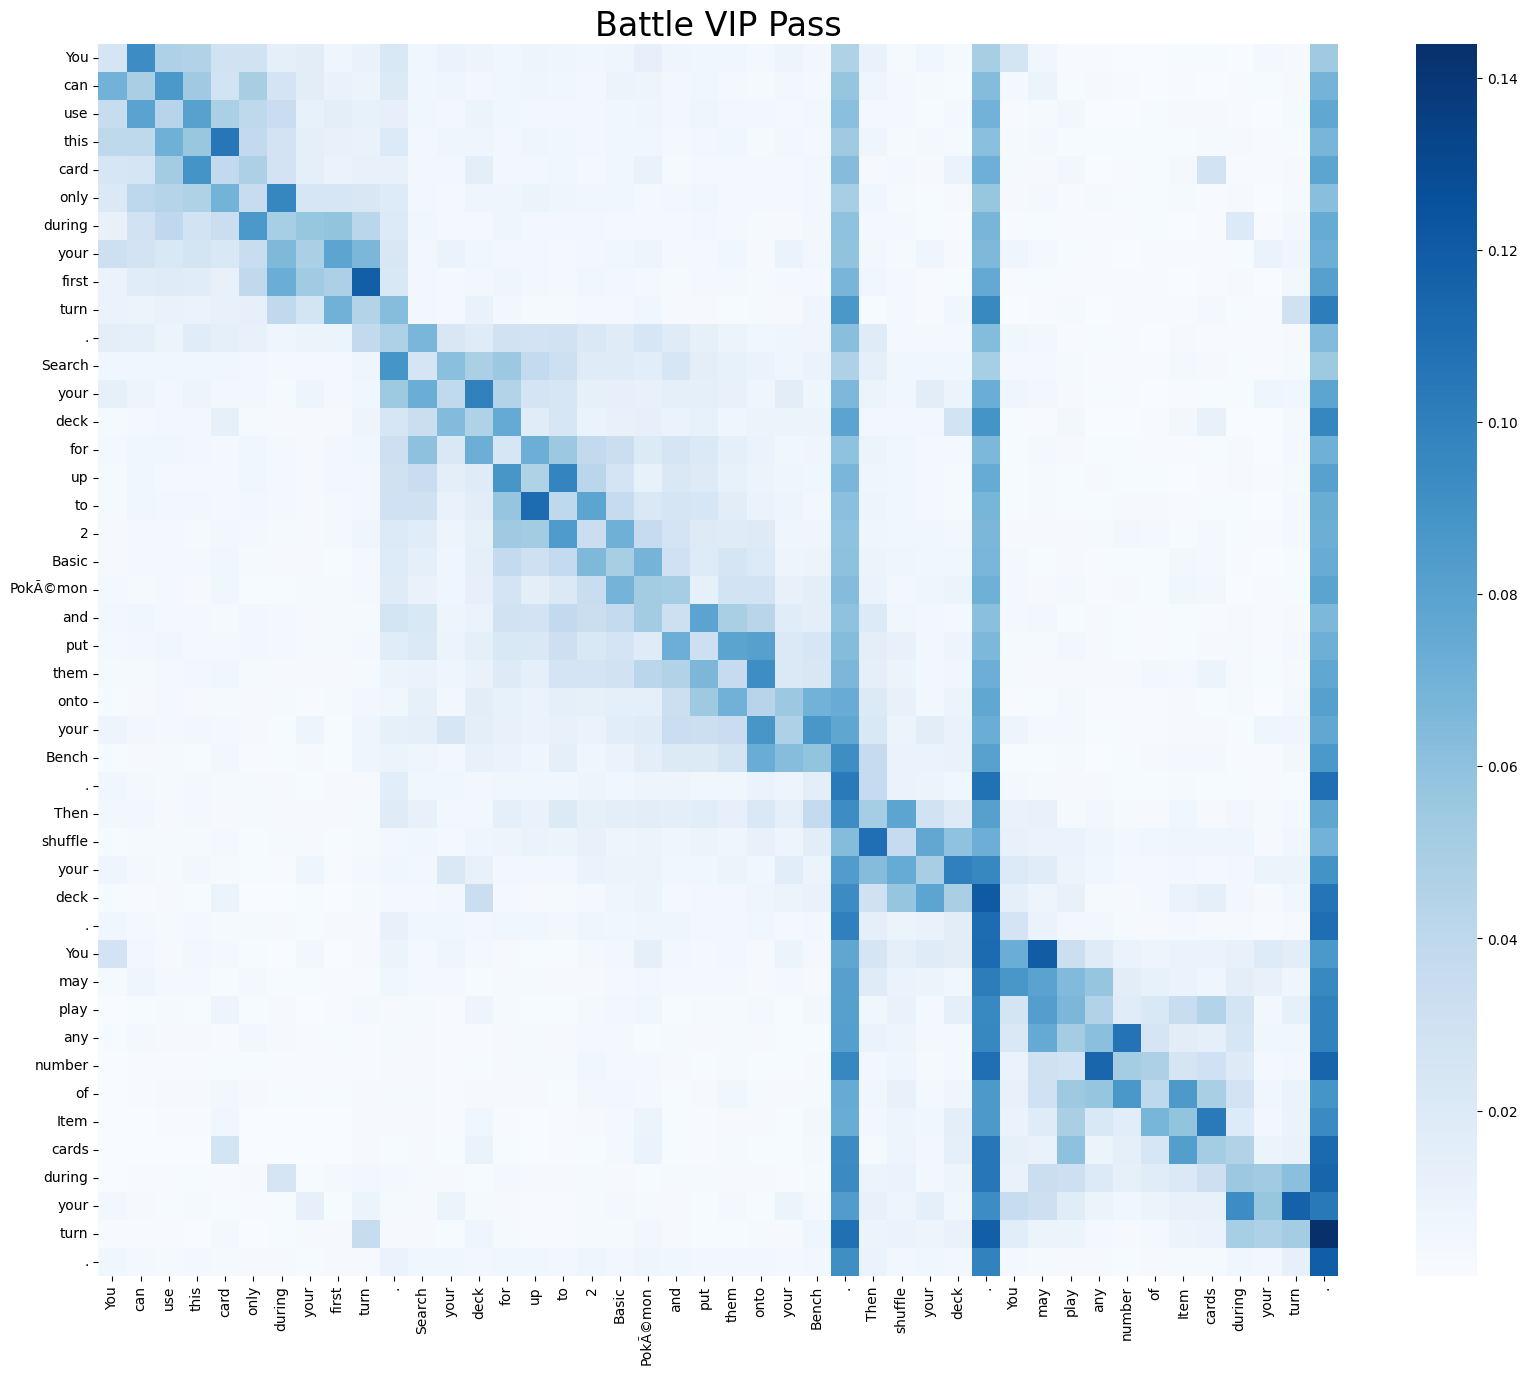

In [76]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[1]),
    pairwise_attentions[1],
    offset=6
)

plt.title(sorted_test_dat_x['name'].iloc[1], fontsize=24);

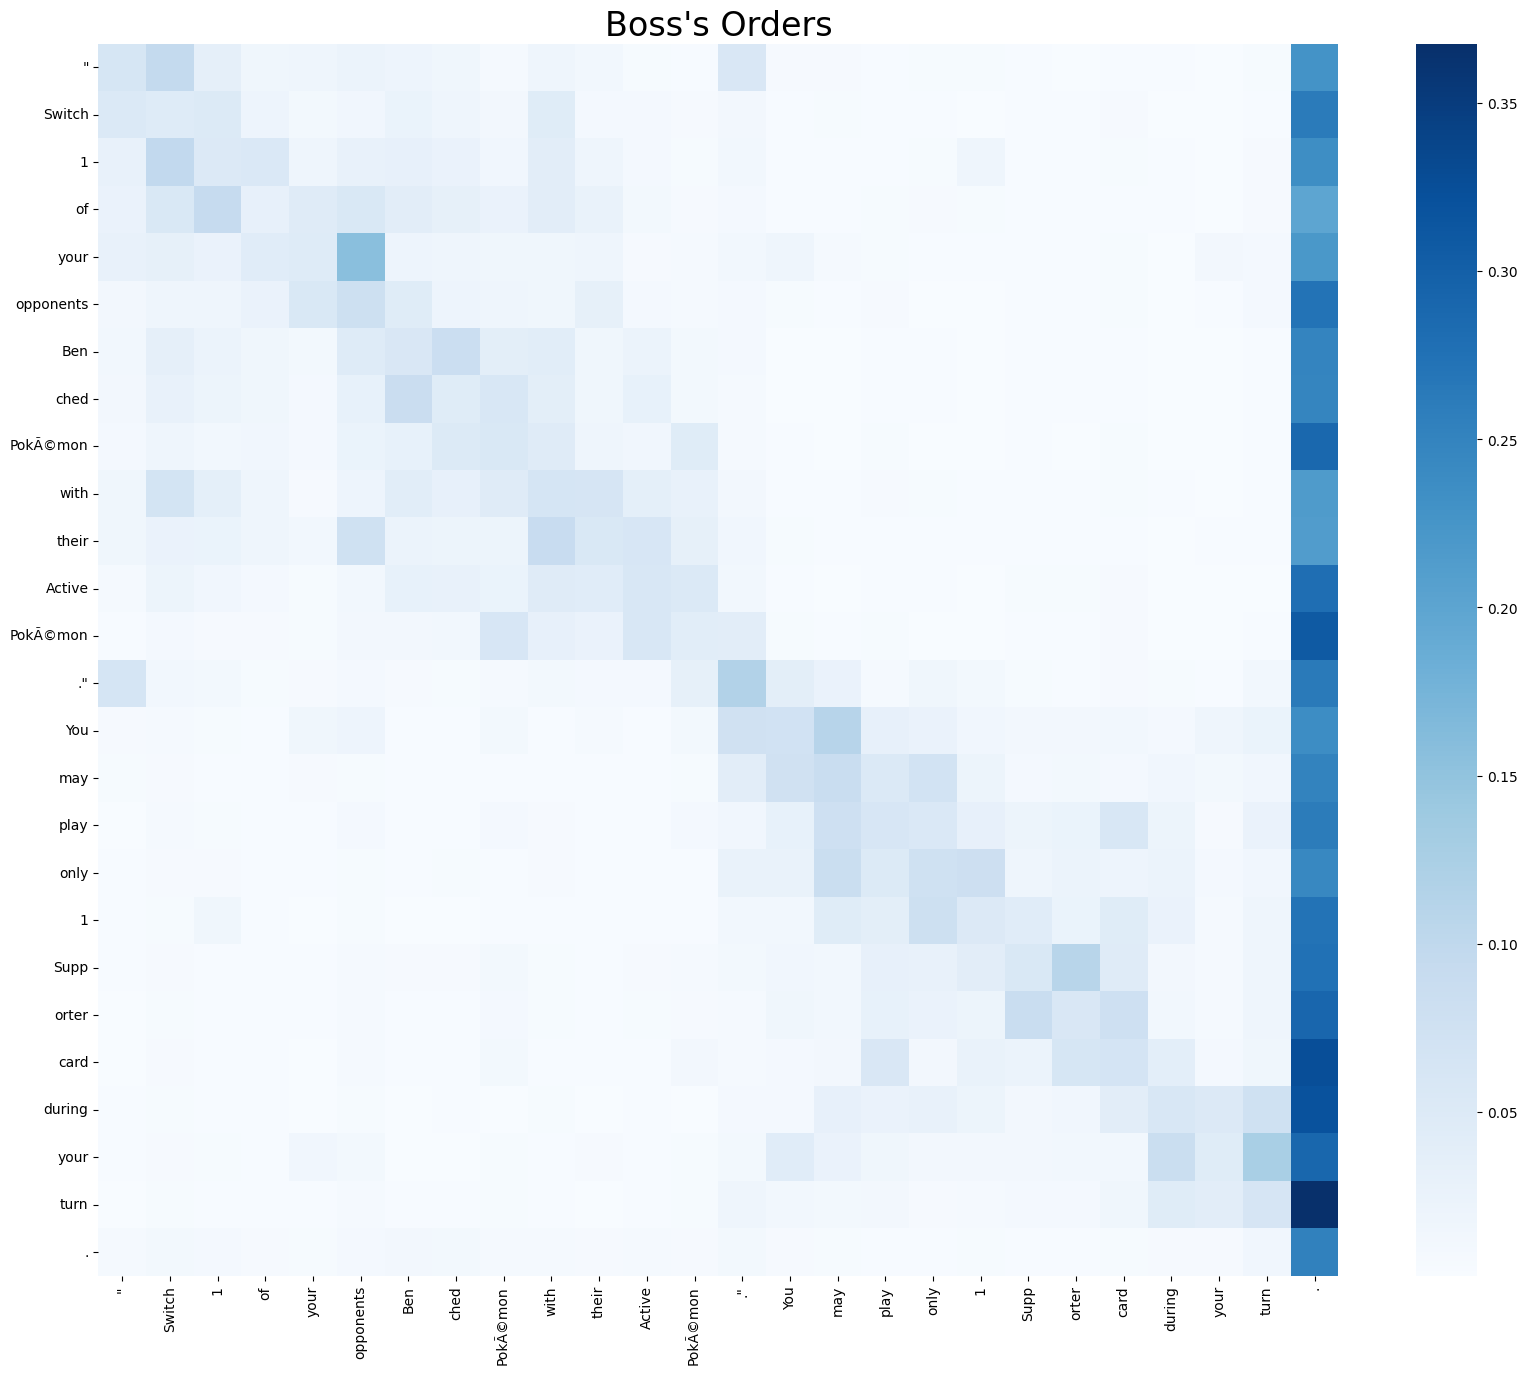

In [78]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[3]),
    pairwise_attentions[3],
    offset=8
)

plt.title(sorted_test_dat_x['name'].iloc[3], fontsize=24);

In [79]:
roberta_model_pokemon = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1, output_hidden_states=True, output_attentions=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [85]:
# Create model

input_ids_pokemon = keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask_pokemon = keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

roberta_output_pokemon = roberta_model_pokemon(input_ids=input_ids_pokemon, attention_mask=attention_mask_pokemon)

logits_pokemon = roberta_output_pokemon.logits

model_pokemon = keras.Model(inputs=[input_ids_pokemon, attention_mask_pokemon], outputs=logits_pokemon)
model_pokemon.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246464   ['input_ids[0][0]',           
 assification_4 (TFRobertaF  (loss=None, logits=(None,    01         'attention_mask[0][0]']      
 orSequenceClassification)   1),                                                            

In [87]:
model_pokemon.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

history = model_pokemon.fit(
    x=dict(train_pokemon_tokenized_text),
    y=train_pokemon_dat_y.reshape(-1,1),
    batch_size=8,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
232/232 [==============================] - 331s 1s/step - loss: 0.0017 - mean_absolute_error: 0.0278 - val_loss: 6.6640e-04 - val_mean_absolute_error: 0.0150
Epoch 2/10
232/232 [==============================] - 235s 1s/step - loss: 0.0014 - mean_absolute_error: 0.0257 - val_loss: 6.0865e-04 - val_mean_absolute_error: 0.0192
Epoch 3/10
232/232 [==============================] - 236s 1s/step - loss: 0.0011 - mean_absolute_error: 0.0216 - val_loss: 5.0391e-04 - val_mean_absolute_error: 0.0082
Epoch 4/10
232/232 [==============================] - 236s 1s/step - loss: 0.0010 - mean_absolute_error: 0.0205 - val_loss: 4.4068e-04 - val_mean_absolute_error: 0.0053
Epoch 5/10
232/232 [==============================] - 236s 1s/step - loss: 9.8570e-04 - mean_absolute_error: 0.0194 - val_loss: 0.0012 - val_mean_absolute_error: 0.0325
Epoch 6/10
232/232 [==============================] - 234s 1s/step - loss: 8.8982e-04 - mean_absolute_error: 0.0180 - val_loss: 4.7611e-04 - val_mean_absol

In [88]:
roberta_model_filename = "RoBERTa_pokemon_fine_tuned_v1"
model_filename = "RoBERTa_pokemon_model.keras_v1"

roberta_model_pokemon.save_pretrained(f"/content/drive/MyDrive/266/project/{roberta_model_filename}")
model_pokemon.save(f"/content/drive/MyDrive/266/project/{model_filename}")
# bert_model = TFRobertaForSequenceClassification.from_pretrained(f"/content/drive/MyDrive/266/project/{roberta_model_filename}")
#loaded_model = keras.saving.load_model(f"/content/drive/MyDrive/266/project/{model_filename}")

In [105]:
idx = np.argsort(test_pokemon_dat_y)[::-1]
sorted_test_dat_y = test_pokemon_dat_y[idx][:10]
sorted_test_dat_x = test_pokemon_dat_x.iloc[idx,:].iloc[:10,:]

X_test_tokenized = tokenizer(
    sorted_test_dat_x[usecols].apply(combine_features, axis=1).tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

roberta_outputs = roberta_model(
    input_ids=X_test_tokenized['input_ids'],
    attention_mask=X_test_tokenized['attention_mask'],
)

attentions = roberta_outputs.attentions
attentions = np.array([att.numpy() for att in attentions])  # Convert to NumPy array. Shape [12, batch_size, 12, num_tokens, num_tokens]. The 12 is number of layers. The other 12 is number of attention heads.


In [106]:
pairwise_attentions = attentions.mean(axis=(0, 2)) # Shape [batch_size, num_tokens, num_tokens]

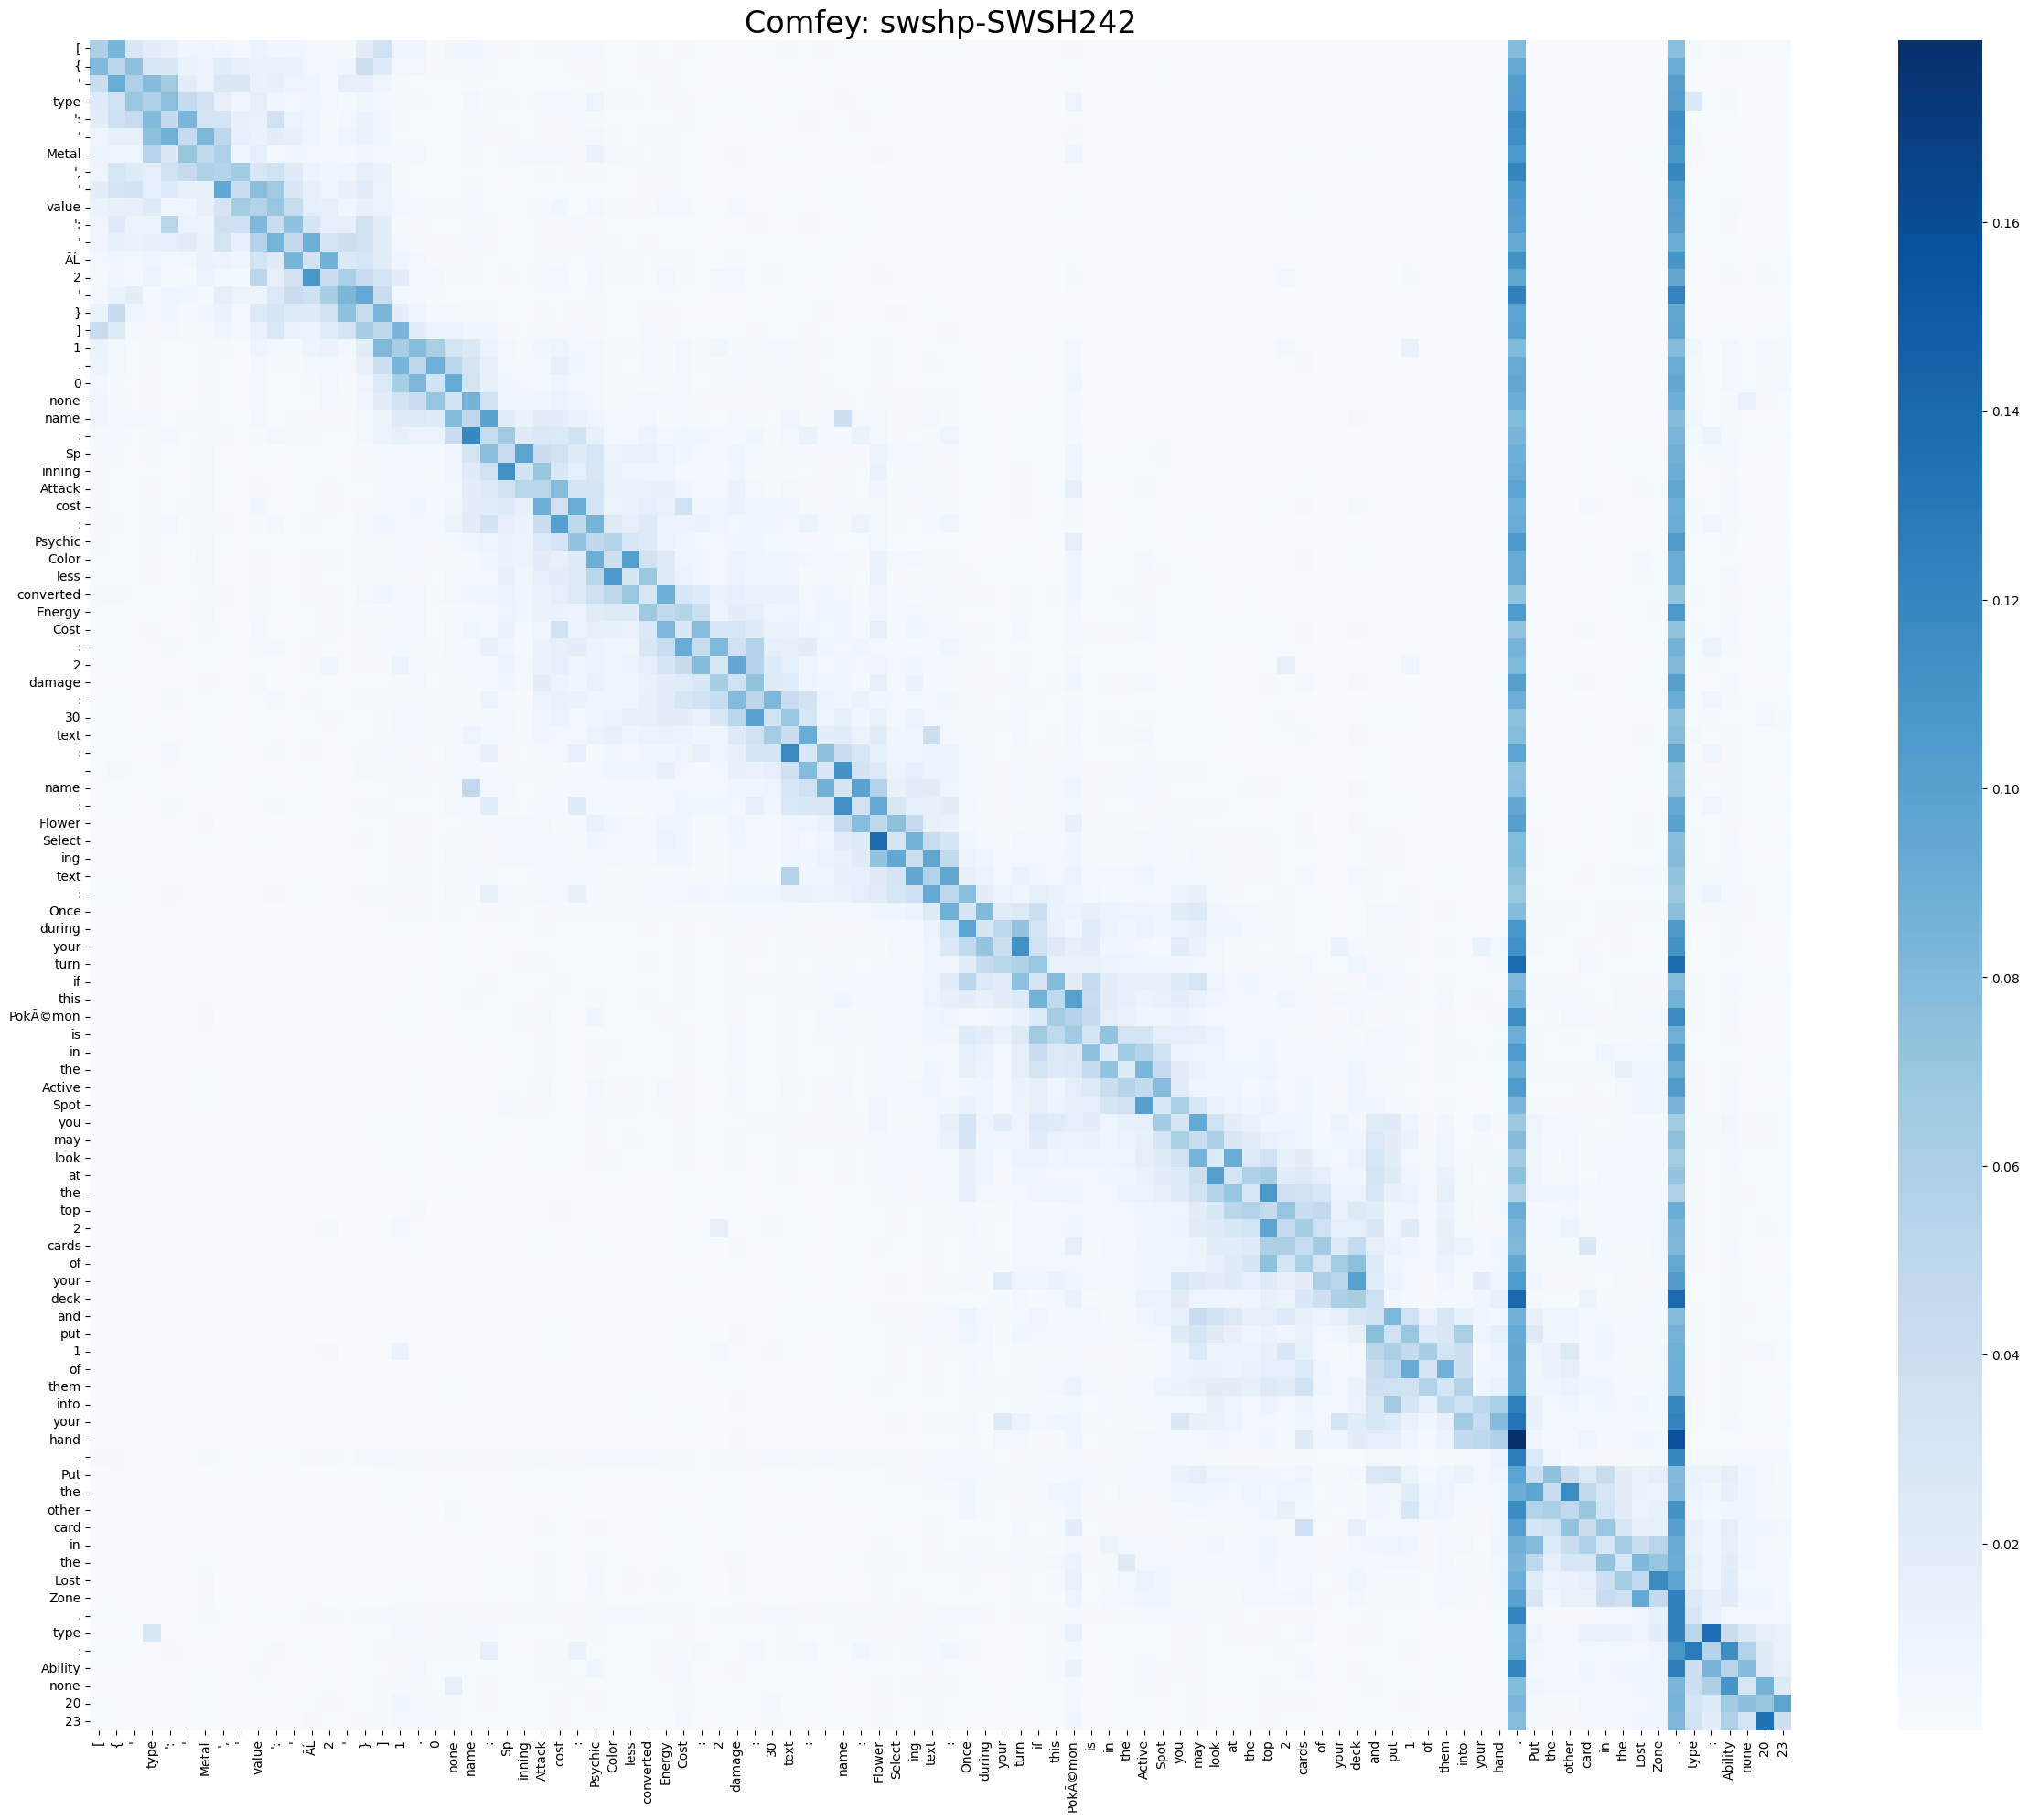

In [120]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[0]),
    pairwise_attentions[0],
    offset=24,
    figsize=(30, 24),

)

plt.title(f"{sorted_test_dat_x['name'].iloc[0]}: {sorted_test_dat_x['id'].iloc[0]}", fontsize=24);

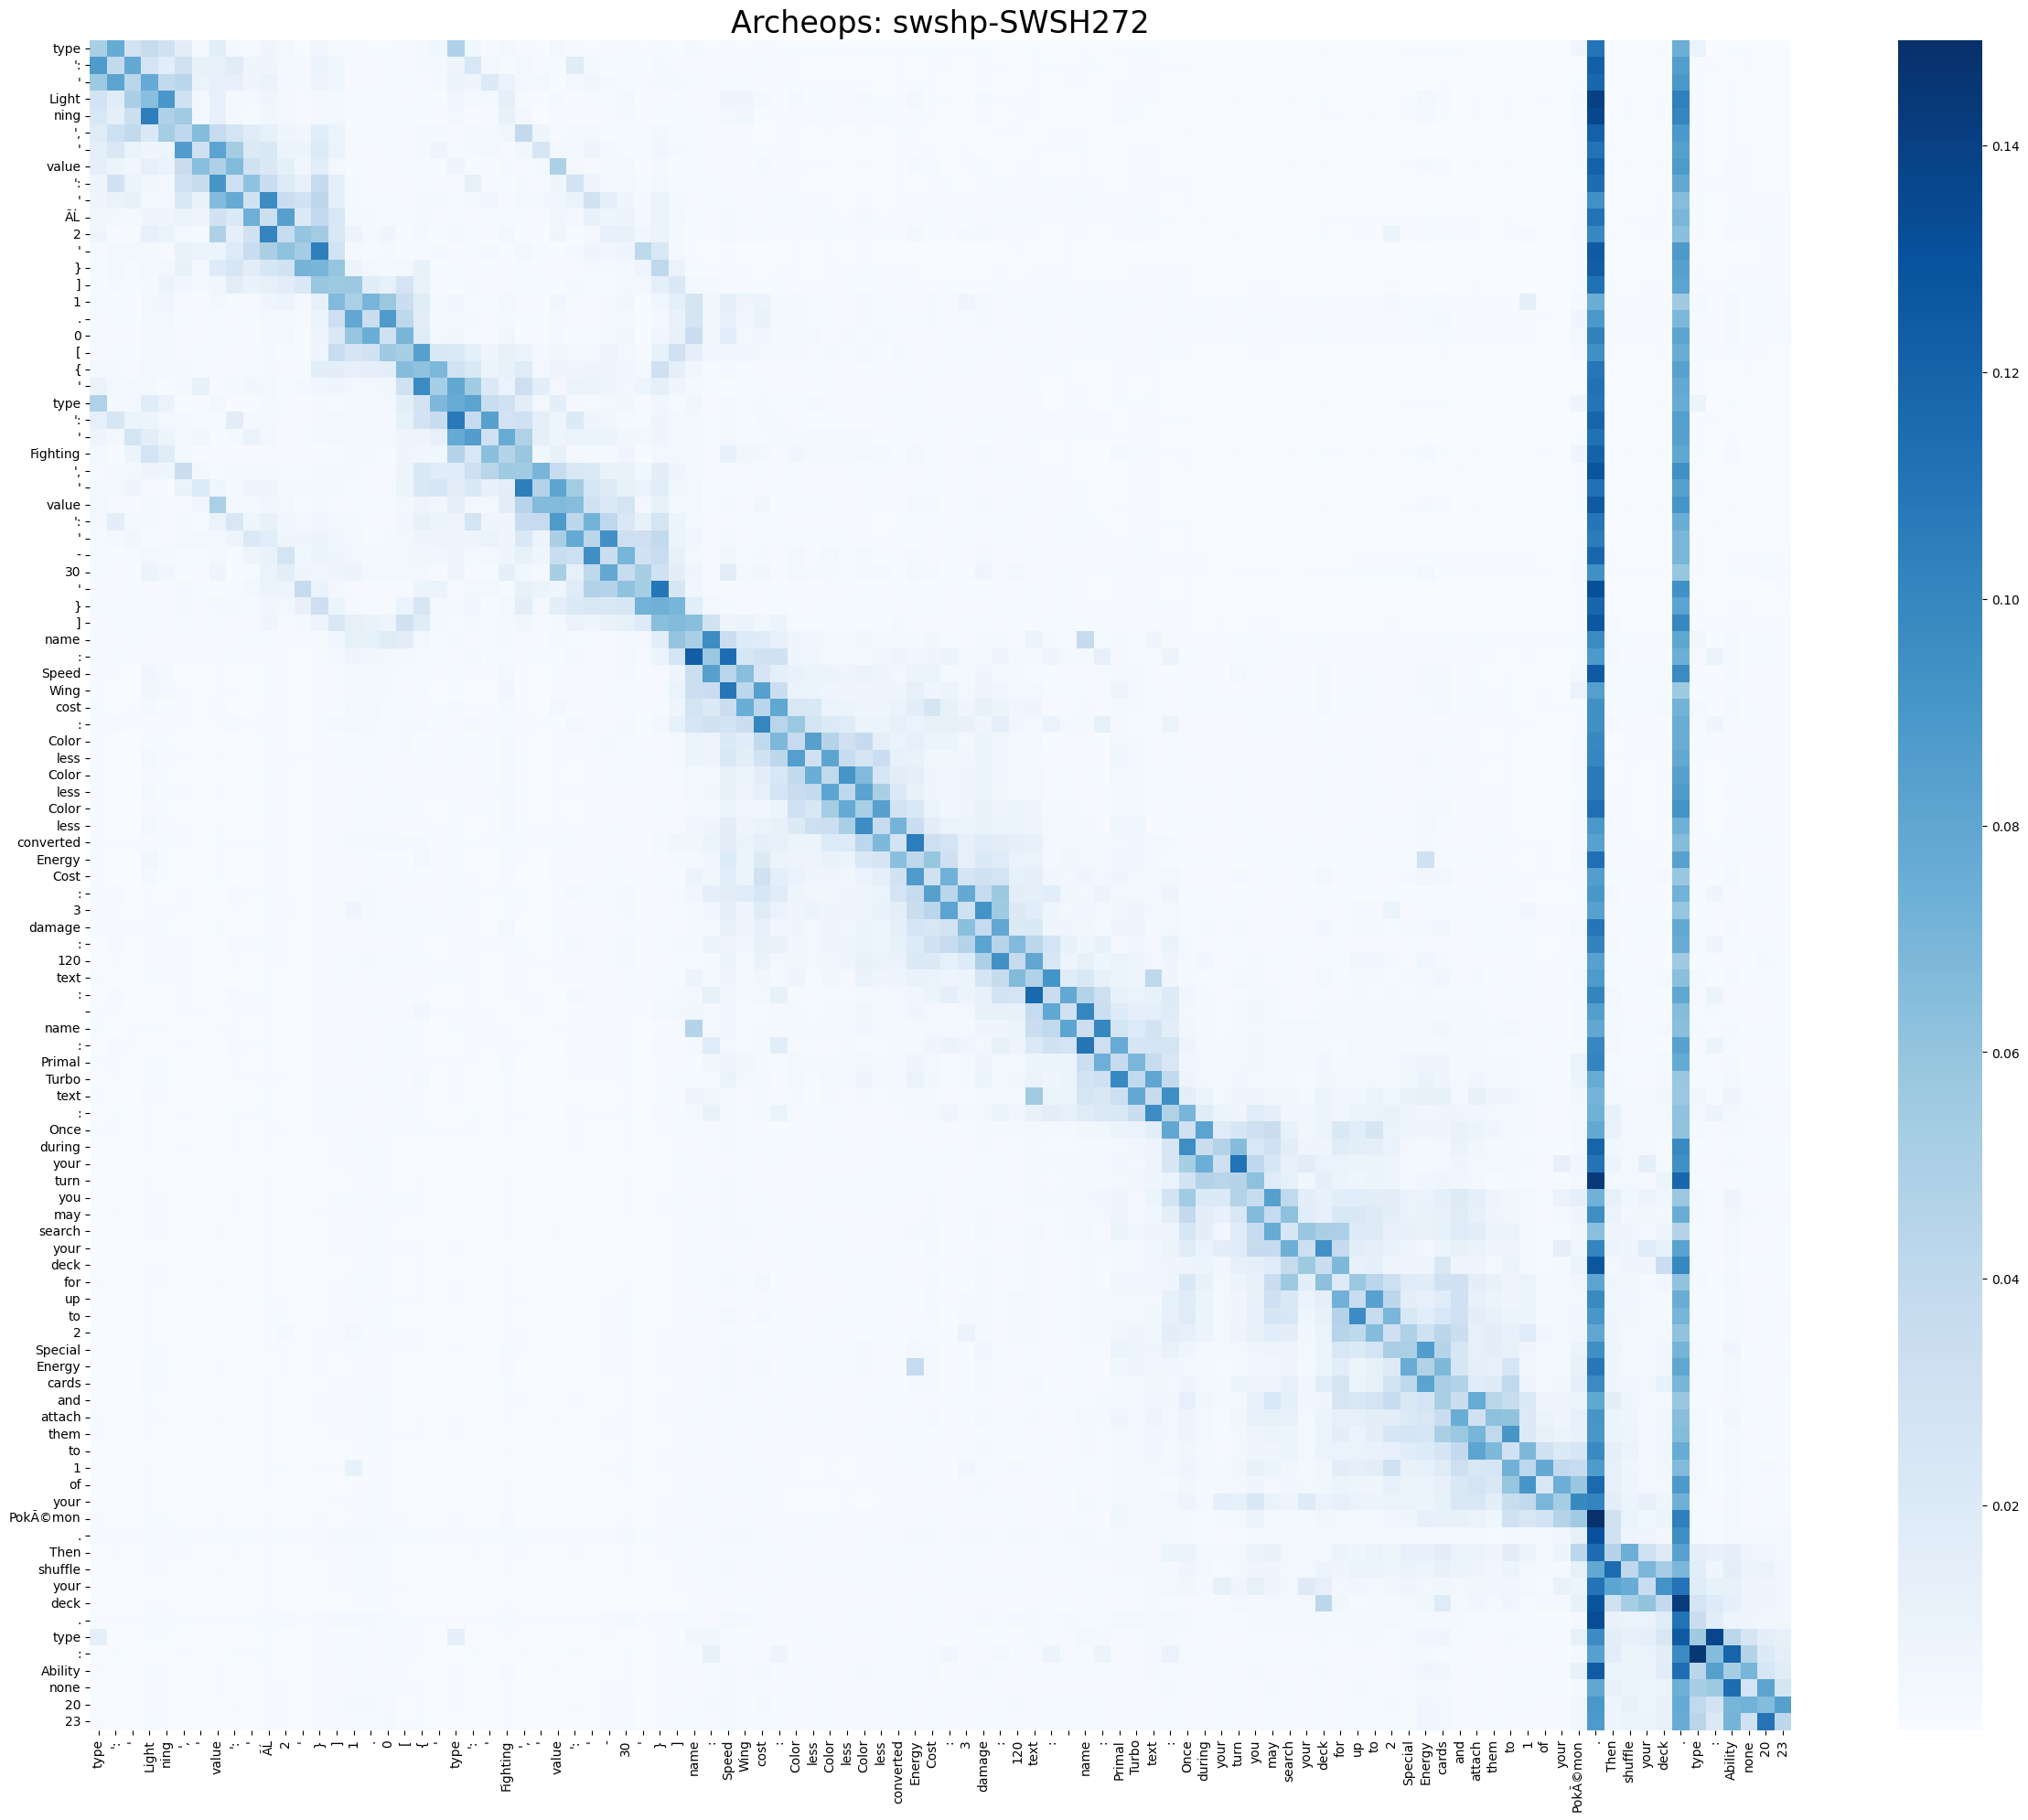

In [122]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[1]),
    pairwise_attentions[1],
    offset=28,
    figsize=(30, 24),
)

plt.title(f"{sorted_test_dat_x['name'].iloc[1]}: {sorted_test_dat_x['id'].iloc[1]}", fontsize=24);

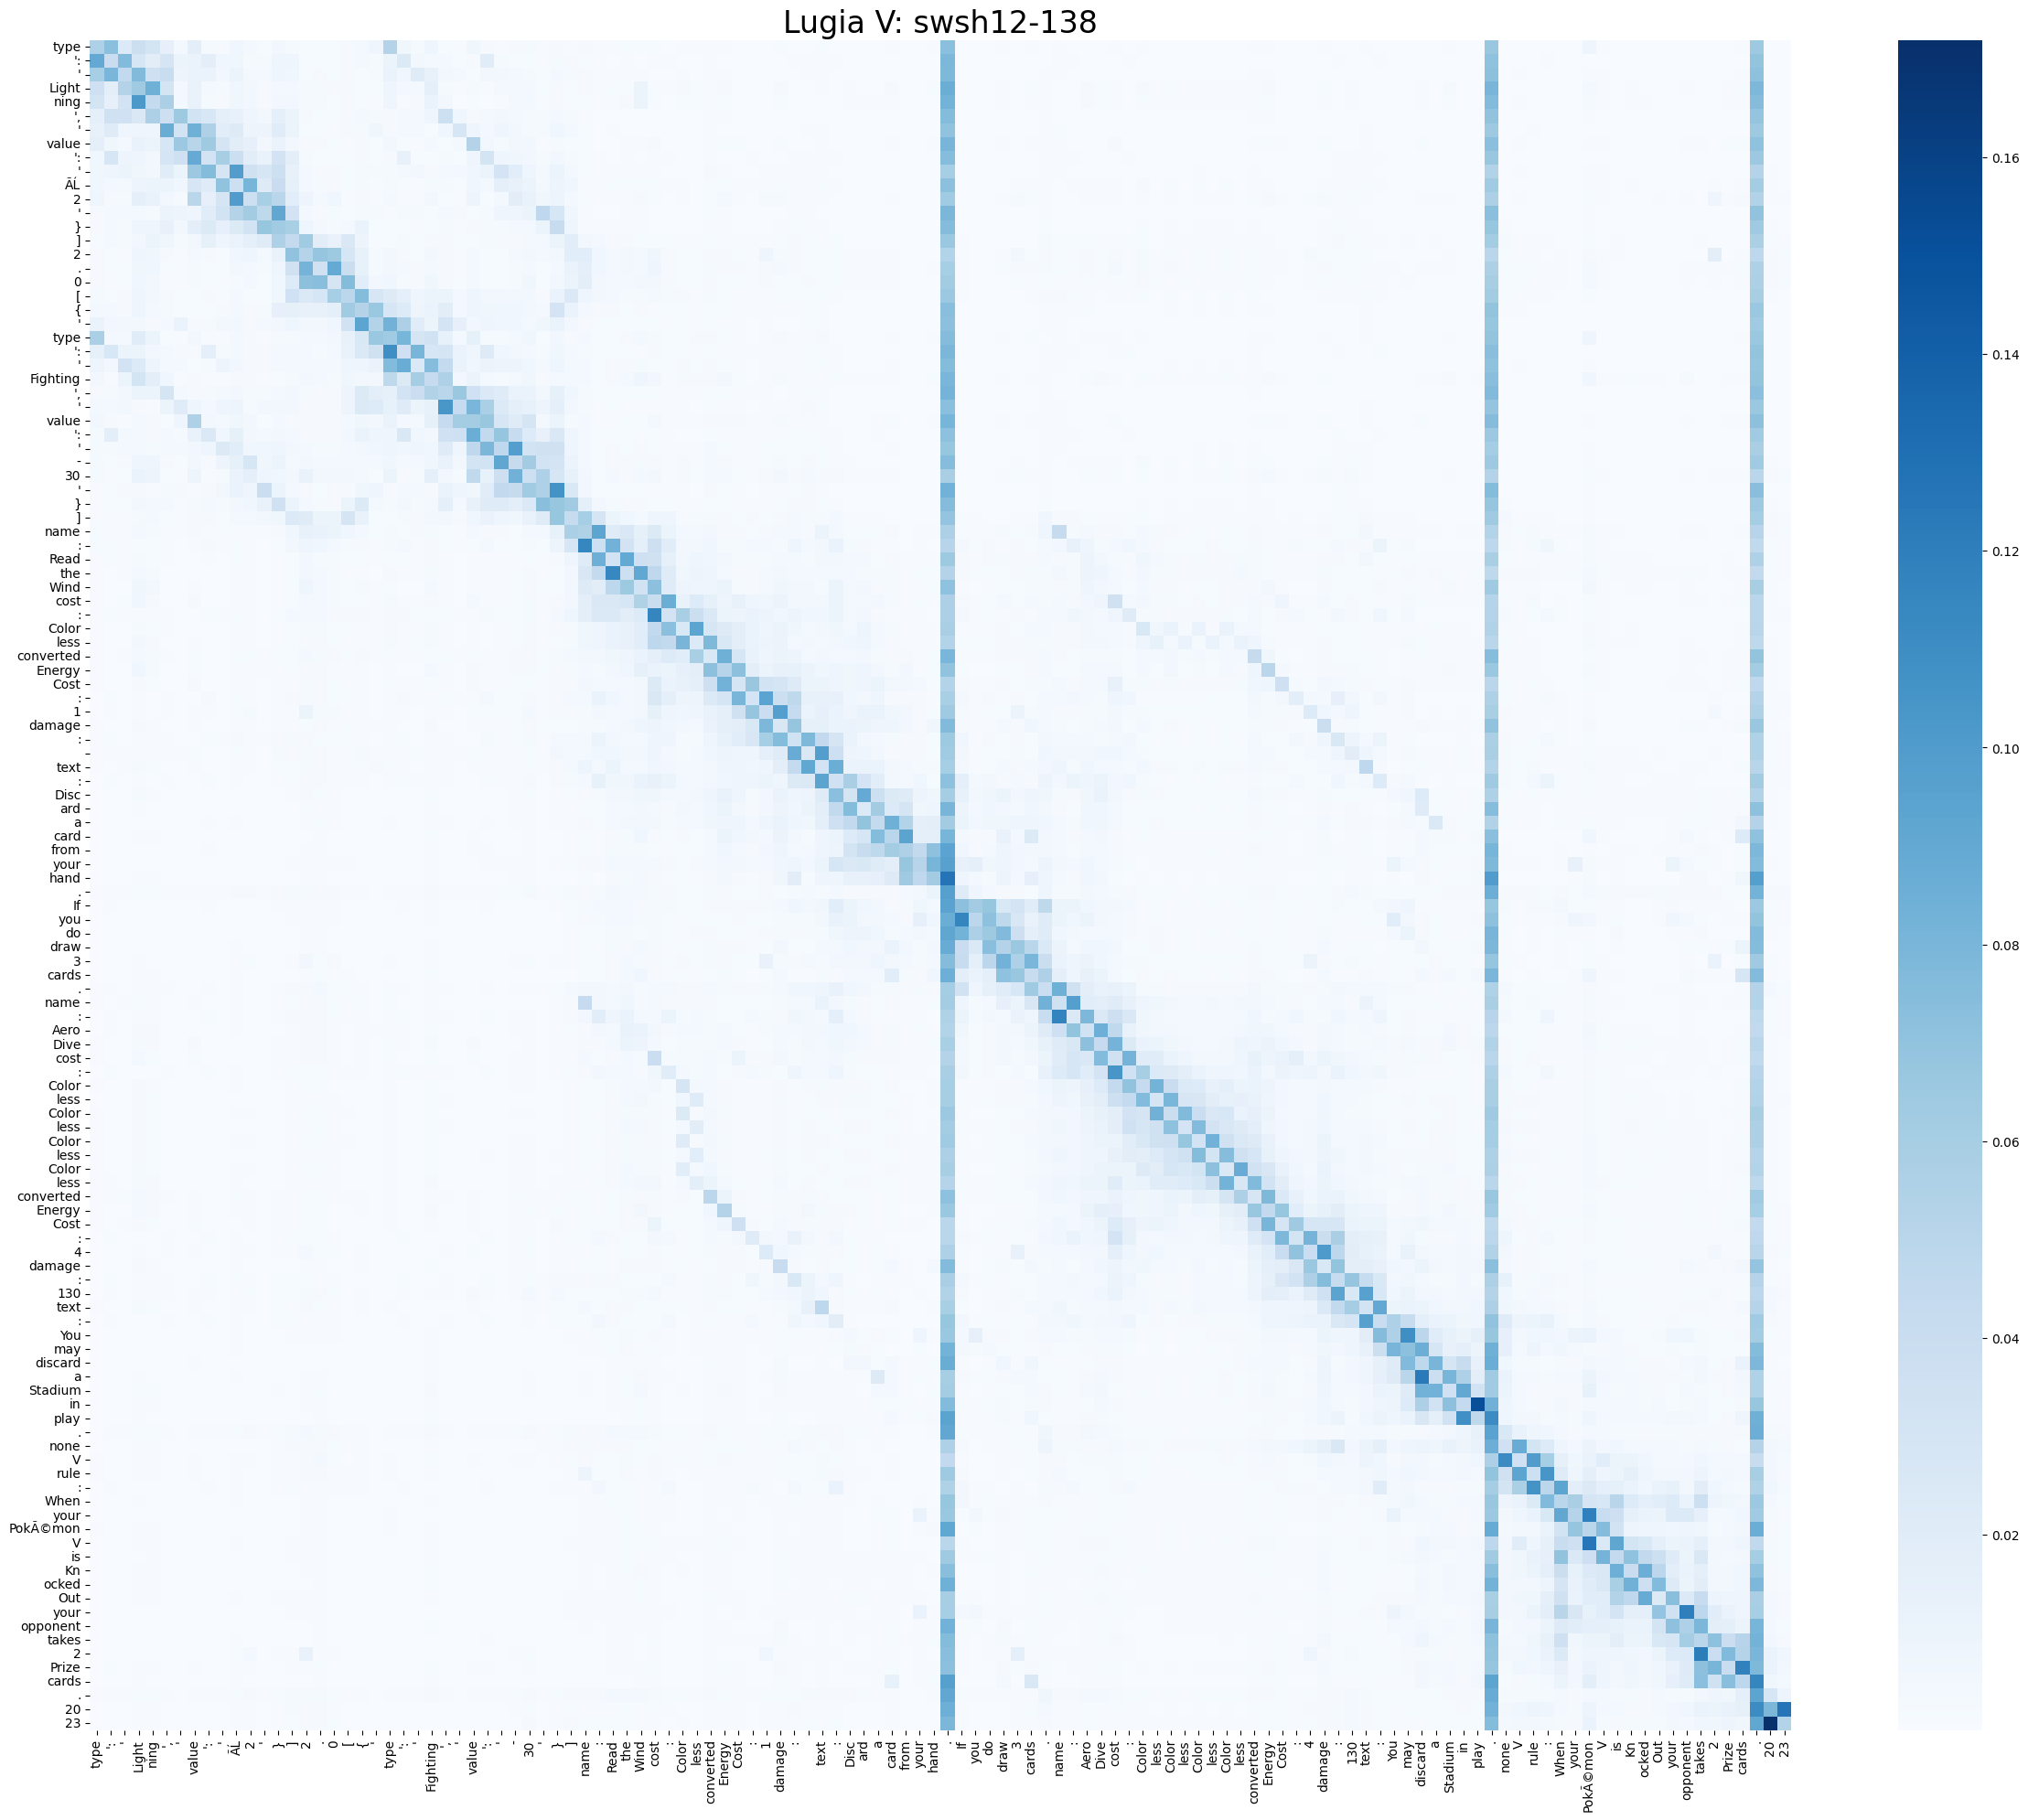

In [123]:
attention_heatmap(
    tokenizer.convert_ids_to_tokens(X_test_tokenized["input_ids"].numpy()[2]),
    pairwise_attentions[2],
    offset=28,
    figsize=(30, 24),
)

plt.title(f"{sorted_test_dat_x['name'].iloc[2]}: {sorted_test_dat_x['id'].iloc[2]}", fontsize=24);